 ### 1- Préparation des données

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt


# Chargement des données
data = pd.read_csv('donnees_nettoyees.csv', sep=";")

# Remplacer les 0 par NaN, puis supprimer les lignes inexploitables
data[['haut_tot', 'haut_tronc', 'tronc_diam']] = data[['haut_tot', 'haut_tronc', 'tronc_diam']].replace(0, pd.NA)
df_clean = data.dropna(subset=['haut_tot', 'tronc_diam'])  # Suppression des lignes avec des valeurs manquantes dans haut_tot ou tronc_diam

# Features nettoyés
features = df_clean[['haut_tot', 'tronc_diam']]

### 2- Apprentissage non-supervisé

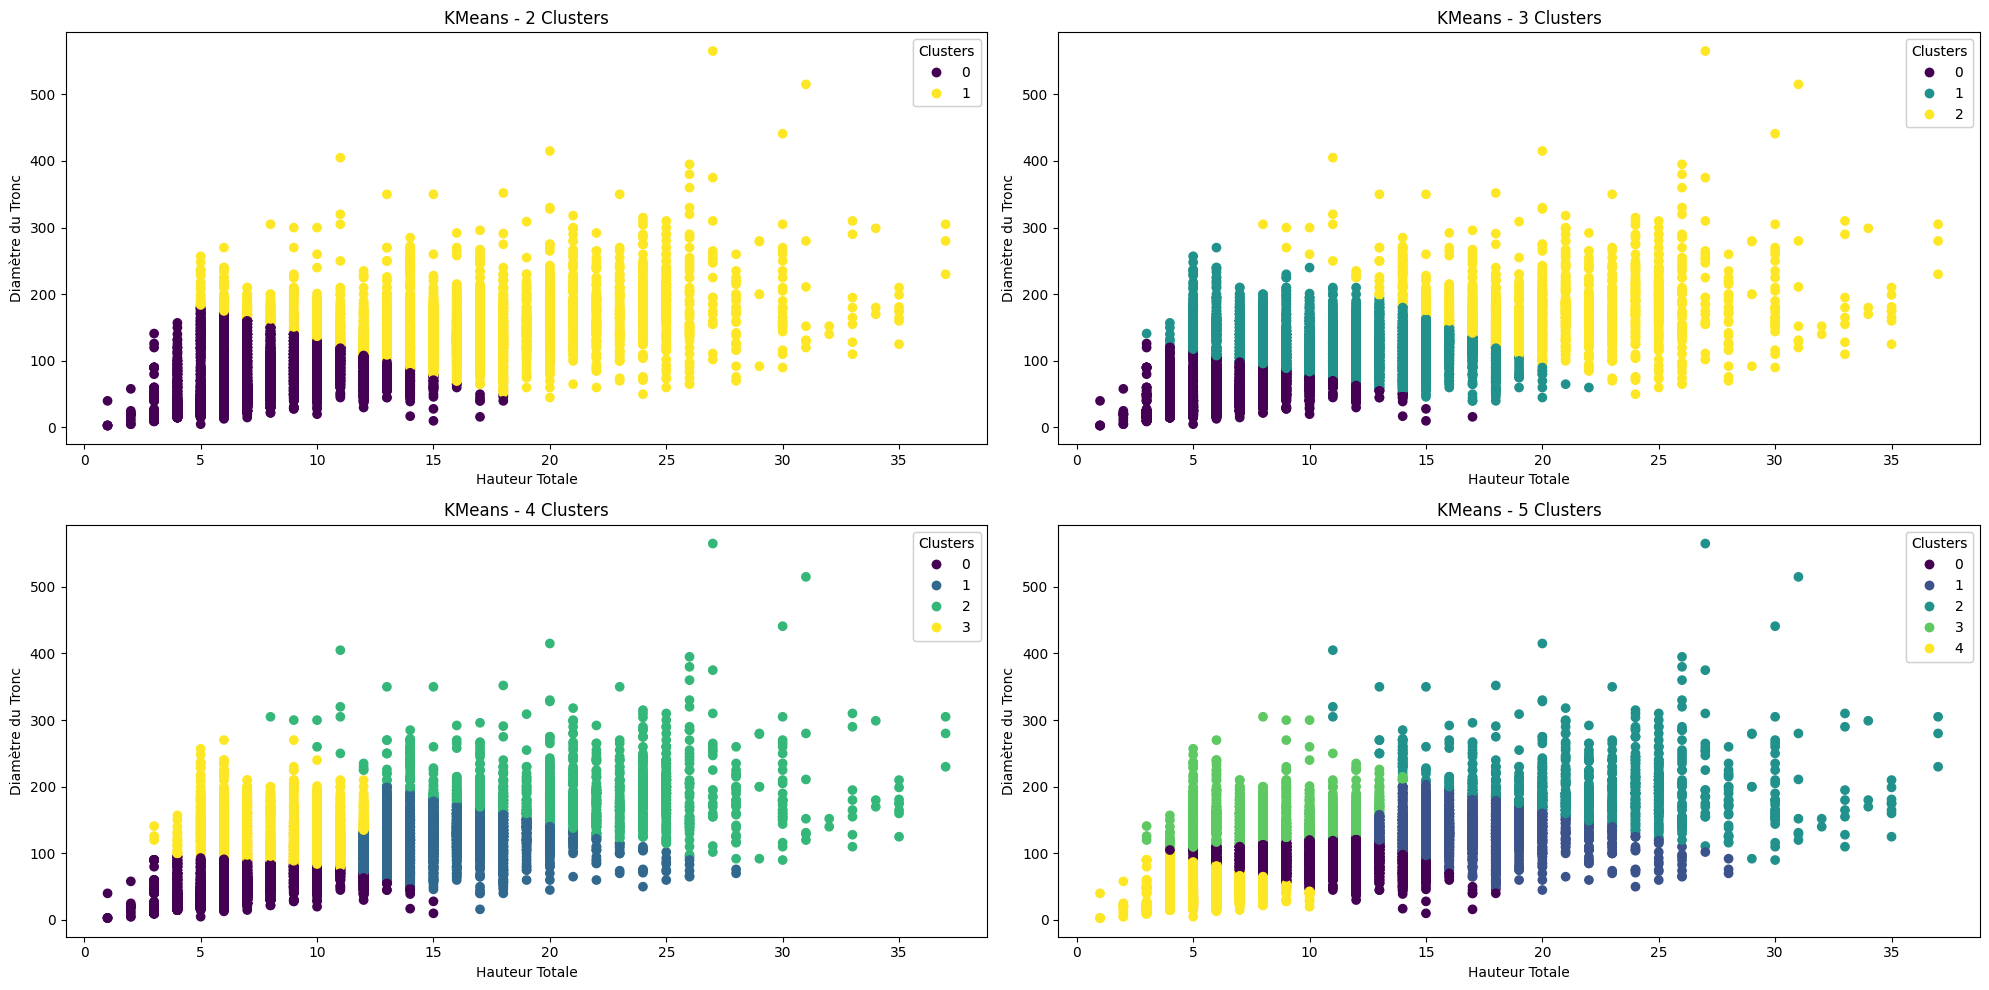

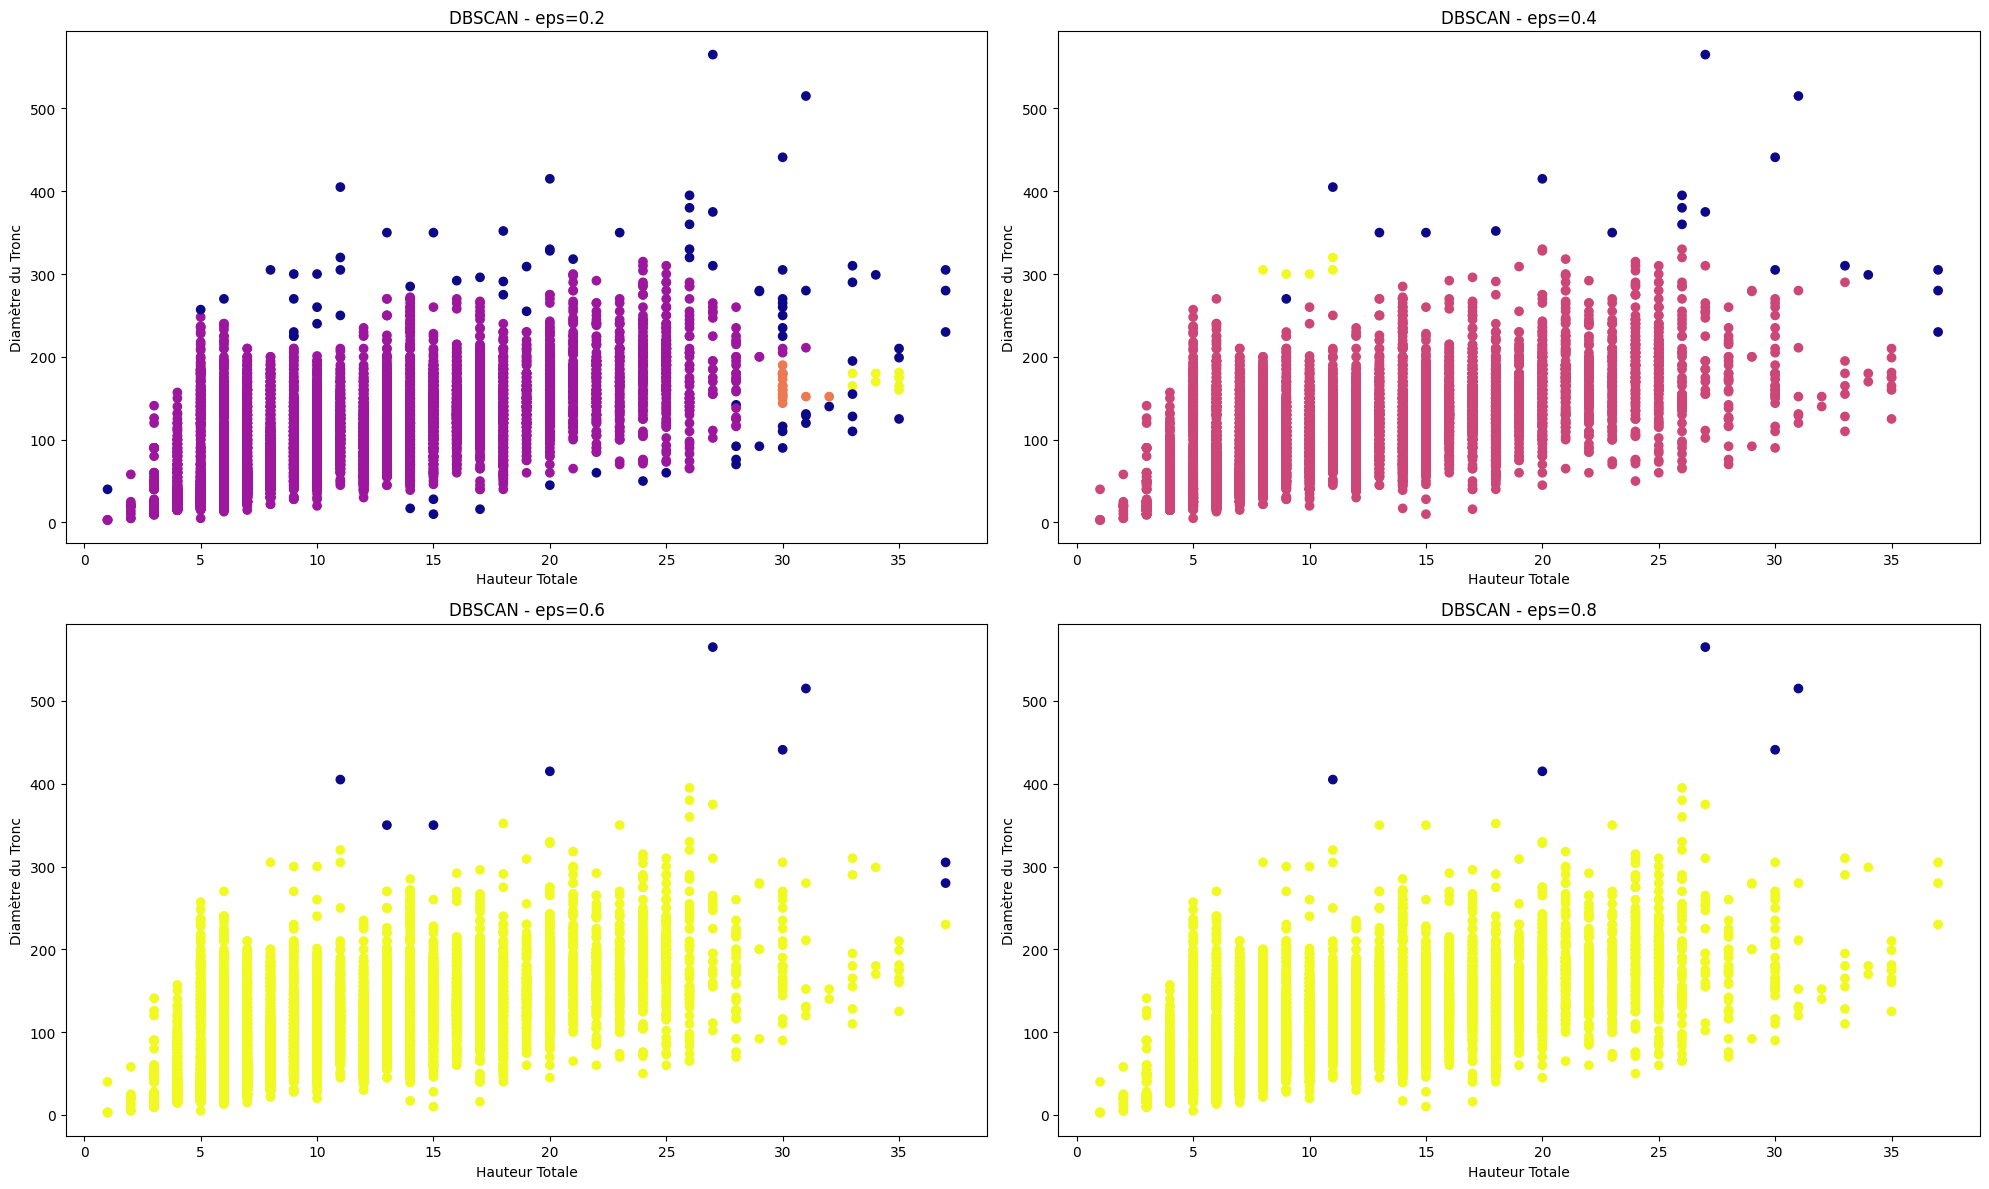

In [3]:
from sklearn.pipeline import Pipeline

# Clustering avec KMeans (tester de 2 à 4 clusters)
kmeans_results = {}
pipelines = {}
for n_clusters in range(2, 6):  # Tester de 2 à 4 clusters
    # On fait un pipeline qui contient la normalisation et le clustering pour pouvoir envoyer toutes les étapes au script
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
    ])
    pipeline.fit(features)
    pipelines[n_clusters] = pipeline
    kmeans_results[n_clusters] = pipeline.named_steps['kmeans'].labels_

# Affichage des résultats de KMeans
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()
for i, n_clusters in enumerate(kmeans_results.keys()):
    ax = axes[i]
    scatter = ax.scatter(df_clean['haut_tot'], df_clean['tronc_diam'], c=kmeans_results[n_clusters], cmap='viridis')
    ax.set_title(f'KMeans - {n_clusters} Clusters')
    ax.set_xlabel('Hauteur Totale')
    ax.set_ylabel('Diamètre du Tronc')
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
plt.tight_layout()
plt.show()

# Normalisation des données
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Clustering avec DBSCAN en faisant varier eps
eps_values = [0.2, 0.4, 0.6, 0.8]  # Liste des valeurs de eps à tester
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for i, eps in enumerate(eps_values):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(features_scaled)

    ax = axes[i]
    scatter = ax.scatter(df_clean['haut_tot'], df_clean['tronc_diam'], c=dbscan_labels, cmap='plasma')
    ax.set_title(f'DBSCAN - eps={eps}')
    ax.set_xlabel('Hauteur Totale')
    ax.set_ylabel('Diamètre du Tronc')


plt.tight_layout()
plt.show()



### 3- Métriques

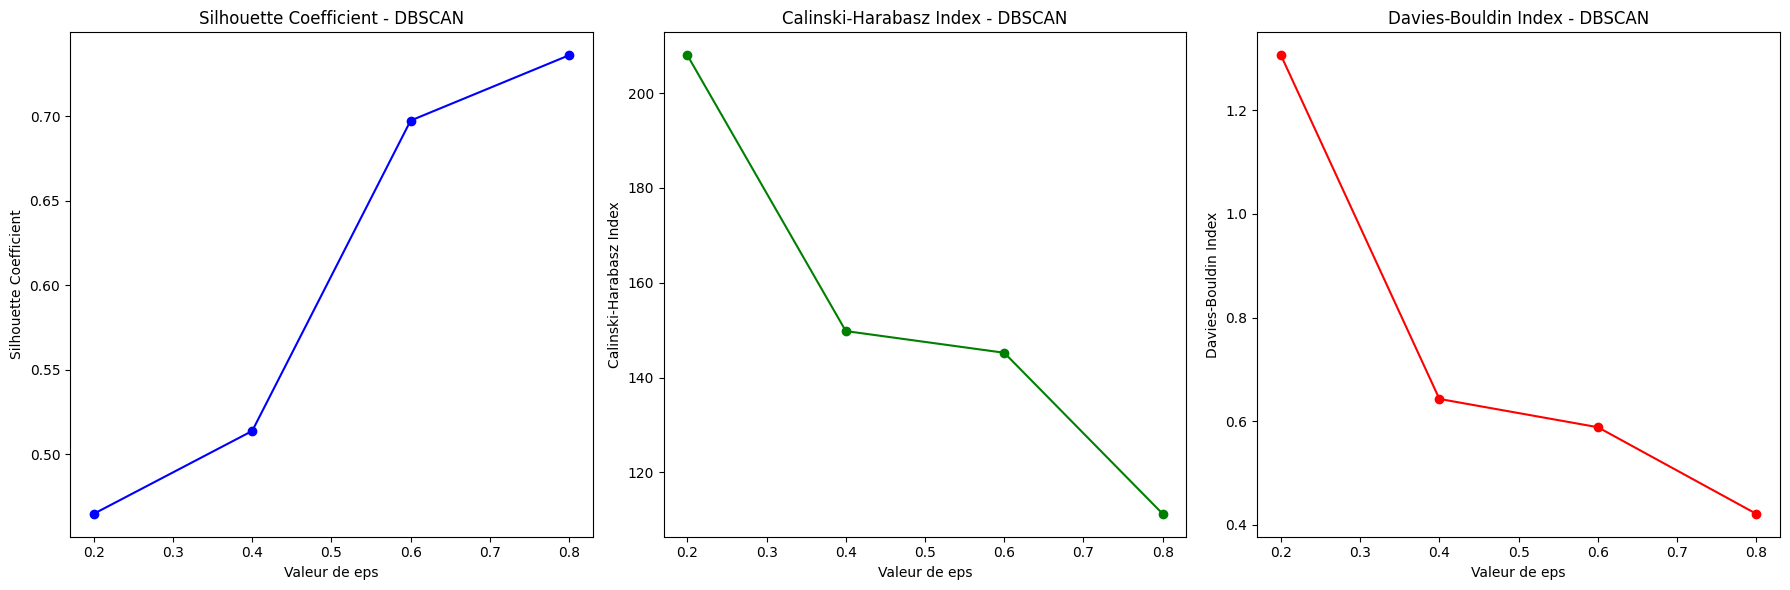

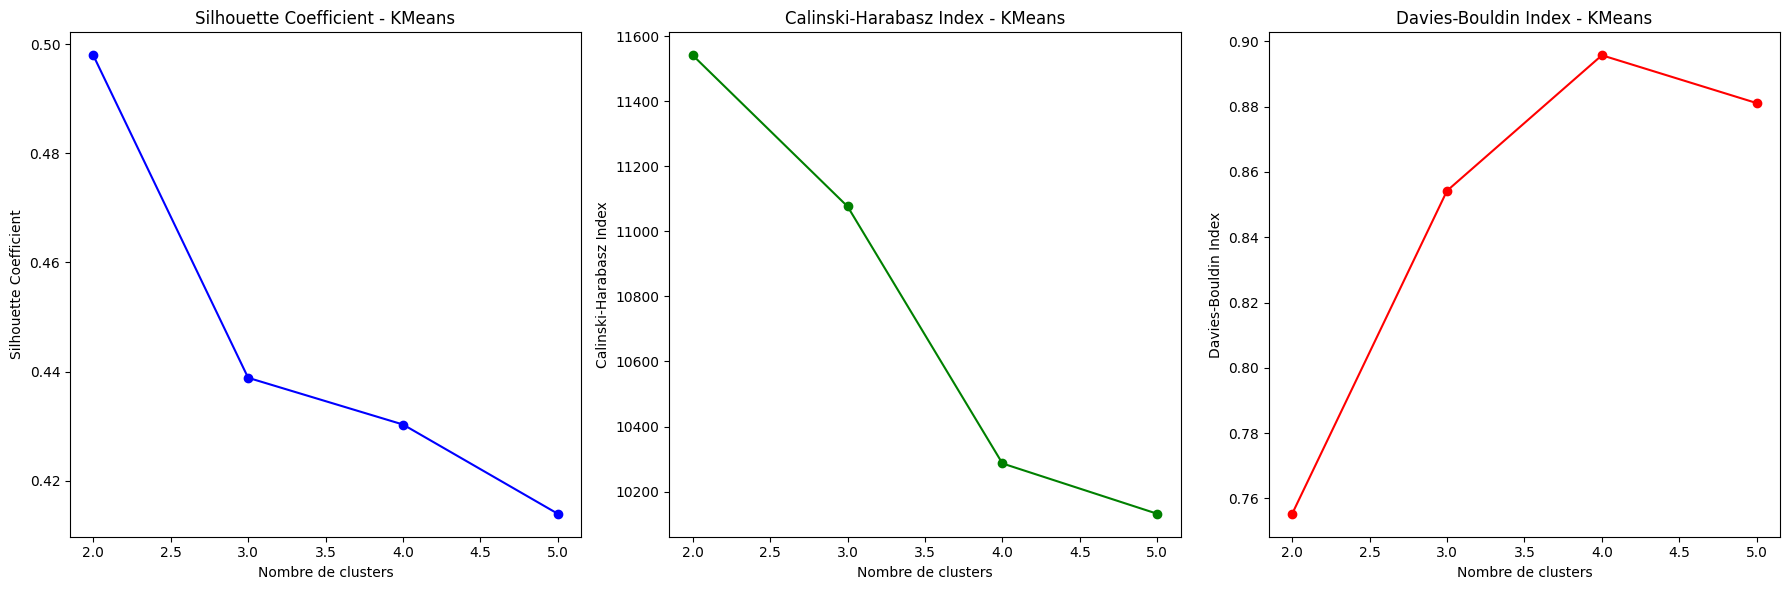

In [4]:
# DBSCAN - Variation de eps de 0.2 à 0.8
eps_values = [0.2, 0.4, 0.6, 0.8]
dbscan_metrics = {
    'Silhouette Coefficient': [],
    'Calinski-Harabasz Index': [],
    'Davies-Bouldin Index': []
}

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(features_scaled)

    # On ne calcule les métriques que si au moins un cluster a été trouvé (sinon le modèle retourne -1 pour les points bruyants)
    if len(set(dbscan_labels)) > 1:
        dbscan_metrics['Silhouette Coefficient'].append(silhouette_score(features_scaled, dbscan_labels))
        dbscan_metrics['Calinski-Harabasz Index'].append(calinski_harabasz_score(features_scaled, dbscan_labels))
        dbscan_metrics['Davies-Bouldin Index'].append(davies_bouldin_score(features_scaled, dbscan_labels))
    else:
        dbscan_metrics['Silhouette Coefficient'].append(float('nan'))
        dbscan_metrics['Calinski-Harabasz Index'].append(float('nan'))
        dbscan_metrics['Davies-Bouldin Index'].append(float('nan'))

# --- Visualisation des métriques pour DBSCAN ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Silhouette Coefficient
axes[0].plot(eps_values, dbscan_metrics['Silhouette Coefficient'], marker='o', linestyle='-', color='blue')
axes[0].set_title('Silhouette Coefficient - DBSCAN')
axes[0].set_xlabel('Valeur de eps')
axes[0].set_ylabel('Silhouette Coefficient')

# Calinski-Harabasz Index
axes[1].plot(eps_values, dbscan_metrics['Calinski-Harabasz Index'], marker='o', linestyle='-', color='green')
axes[1].set_title('Calinski-Harabasz Index - DBSCAN')
axes[1].set_xlabel('Valeur de eps')
axes[1].set_ylabel('Calinski-Harabasz Index')

# Davies-Bouldin Index
axes[2].plot(eps_values, dbscan_metrics['Davies-Bouldin Index'], marker='o', linestyle='-', color='red')
axes[2].set_title('Davies-Bouldin Index - DBSCAN')
axes[2].set_xlabel('Valeur de eps')
axes[2].set_ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

# KMeans - Variation du nombre de clusters
metrics = {
    'Silhouette Coefficient': [],
    'Calinski-Harabasz Index': [],
    'Davies-Bouldin Index': []
}

range_n_clusters = range(2, 6)  # De 2 à 5 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(features_scaled)

    metrics['Silhouette Coefficient'].append(silhouette_score(features_scaled, kmeans_labels))
    metrics['Calinski-Harabasz Index'].append(calinski_harabasz_score(features_scaled, kmeans_labels))
    metrics['Davies-Bouldin Index'].append(davies_bouldin_score(features_scaled, kmeans_labels))

# --- Visualisation des métriques pour KMeans ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Silhouette Coefficient
axes[0].plot(range_n_clusters, metrics['Silhouette Coefficient'], marker='o', linestyle='-', color='blue')
axes[0].set_title('Silhouette Coefficient - KMeans')
axes[0].set_xlabel('Nombre de clusters')
axes[0].set_ylabel('Silhouette Coefficient')

# Calinski-Harabasz Index
axes[1].plot(range_n_clusters, metrics['Calinski-Harabasz Index'], marker='o', linestyle='-', color='green')
axes[1].set_title('Calinski-Harabasz Index - KMeans')
axes[1].set_xlabel('Nombre de clusters')
axes[1].set_ylabel('Calinski-Harabasz Index')

# Davies-Bouldin Index
axes[2].plot(range_n_clusters, metrics['Davies-Bouldin Index'], marker='o', linestyle='-', color='red')
axes[2].set_title('Davies-Bouldin Index - KMeans')
axes[2].set_xlabel('Nombre de clusters')
axes[2].set_ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

### 4- Affichage des clusters sur une carte

In [5]:
from map import createDiscreteMap

df_map = df_clean.copy()

for n_clusters, labels in kmeans_results.items():
    df_map[f'{n_clusters}_clusters'] = labels

createDiscreteMap(df_map, "2_clusters", values = [0,1], colors = ["purple", "yellow"])
createDiscreteMap(df_map, "3_clusters", values = [0,1], colors = ["purple", "yellow"])
createDiscreteMap(df_map, "4_clusters", values = [0,1], colors = ["purple", "yellow"])
createDiscreteMap(df_map, "5_clusters", values = [0,1], colors = ["purple", "yellow"])

### 5- Création de scripts utilisables en ligne de commande


In [6]:
# Sauvegarde du modèle dans un fichier pour appel dans le script
import joblib

joblib.dump(pipelines[2], 'kmeans_haut_tot_from_diam_tronc_2_clusters.pkl')
joblib.dump(pipelines[3], 'kmeans_haut_tot_from_diam_tronc_3_clusters.pkl')

['kmeans_haut_tot_from_diam_tronc_3_clusters.pkl']